In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import networkx as nx
import community.community_louvain as cl
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import copy
import pickle

import time
from tqdm import tqdm

# preprocessed dataset loading

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Data/comtradedata/df_2006_2021_1001.csv")
df.head()

,Unnamed: 0,Year,From,To,Trade Value (US$)
0,0,2006,Algeria,Egypt,5452264
1,1,2006,Andorra,Lebanon,1
2,2,2006,"Areas, nes",Aruba,14580
3,3,2006,"Areas, nes",Côte d'Ivoire,339
4,4,2006,"Areas, nes",Ireland,1575677


In [ ]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

,Year,From,To,Trade Value (US$)
0,2006,Algeria,Egypt,5452264
1,2006,Andorra,Lebanon,1
2,2006,"Areas, nes",Aruba,14580
3,2006,"Areas, nes",Côte d'Ivoire,339
4,2006,"Areas, nes",Ireland,1575677


# 2022 Dataset of Korea

In [ ]:
df1 = df[df['Year']==2021].copy()

In [ ]:
df1 = df1.loc[(df1['From'] != 'Russian Federation') & (df1['From'] != 'Ukraine') & (df1['From'] != 'India')
                                & (df1['To'] != 'Russian Federation') & (df1['To'] != 'Ukraine')]

In [ ]:
df_K_2022 = df1.loc[(df1['From'] == 'Rep. of Korea') | (df1['To'] == 'Rep. of Korea')].copy()

In [ ]:
Country_list_2022 = pd.concat([df_K_2022.loc[df_K_2022['Year'] == 2021]['From'], df_K_2022.loc[df_K_2022['Year'] == 2021]['To']], ignore_index=True).unique()

In [ ]:
cont_idx = []

for idx, row in df1.iterrows():
    in_From = row['From'] in Country_list_2022
    in_To = row['To'] in Country_list_2022
    
    if in_From & in_To:
        cont_idx.append(idx)

df_relatedK_2022 = df1.loc[cont_idx].copy()

In [ ]:
df_relatedK_2022['Year']=2022
df_relatedK_2022

,Year,From,To,Trade Value (US$)
29329,2022,Australia,Netherlands,714
29336,2022,Australia,Philippines,1132638137
29338,2022,Australia,Rep. of Korea,311250701
29402,2022,Belgium,Germany,35110172
29412,2022,Belgium,Netherlands,205088291
...,...,...,...,...
30631,2022,USA,Canada,110933615
30646,2022,USA,Germany,1869248
30671,2022,USA,Netherlands,3226
30677,2022,USA,Philippines,1867700762


# 2006 ~ 2022 Korea Dataset

In [ ]:
# Test
print(df_relatedK_2022[df_relatedK_2022['From'] == 'Russian Federation'])
print(df_relatedK_2022[df_relatedK_2022['From'] == 'Ukraine'])
print(df_relatedK_2022[df_relatedK_2022['From'] == 'India'])
print(df_relatedK_2022[df_relatedK_2022['To'] == 'Russian Federation'])
print(df_relatedK_2022[df_relatedK_2022['To'] == 'Ukraine'], '\n')
print(df_relatedK_2022[df_relatedK_2022['To'] == 'India'])
# successfully eliminated

Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []
Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: [] 

Empty DataFrame
Columns: [Year, From, To, Trade Value (US$)]
Index: []


## korea central graph making

In [ ]:
wheat_korea = nx.from_pandas_edgelist(df_relatedK_2022, source='From', target='To', 
                                                 edge_attr='Trade Value (US$)', create_using=nx.DiGraph()) # Directed Graph

In [ ]:
# finding independent, moderate, dependent node in Graph
def nodeDependency(G):
  indep_nodes = []
  moderate_nodes = []
  dep_nodes = []
  for node in list(G.nodes()):
      ratio = G.out_degree(node, weight='Trade Value (US$)') / (G.out_degree(node, weight='Trade Value (US$)') + G.in_degree(node, weight='Trade Value (US$)'))
      dep_nodes.append(node) if ratio < 0.3 else indep_nodes.append(node) if ratio > 0.7 else moderate_nodes.append(node)

  return indep_nodes, moderate_nodes, dep_nodes

In [ ]:
def DiGraphPlot(G, year):
    fig, ax = plt.subplots()
    fig.set_size_inches((32, 32))
    
    plt.rcParams.update({
        "figure.facecolor":  (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
        "savefig.facecolor": (1.0, 229/255, 204/255, 0.3),  # with alpha = 30%
    })

    # nodelist by dependency
    indep_nodes, moderate_nodes, dep_nodes = nodeDependency(G)
    
    ## layout 설정
    layout = {"circular layout of Countries related to Korea in {}".format(year) : nx.circular_layout(G)}
              
    for _, item in enumerate(layout.items()):
        title, pos = item[0], item[1]
        nx.draw_networkx(G, pos=pos, font_color="white", ax=ax, font_size=12)
        
        # 수입 의존도가 낮은 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = indep_nodes,
                               node_color="tab:blue",
                               node_size = 10000)        
        
        # 수입 수출량이 비슷한 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = moderate_nodes,
                               node_color="green",
                               node_size = 10000)

        # 수입 의존도가 높은 노드
        nx.draw_networkx_nodes(G, pos,
                               nodelist = dep_nodes,
                               node_color="tab:red",
                               node_size = 10000)
        
        # arrow style 지정
        nx.draw_networkx_edges(G, pos, edge_color='k', arrowsize=25, connectionstyle='arc3', min_target_margin=60)

        
        ax.set_title(title, fontsize=40)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"/content/drive/Shareddrives/22-1 데이터마이닝/TermProject/Louvain_Analysis/Korea/korea_Ntwk_in_2022.png",
                # dpi = 200, # 해상도
                bbox_inches='tight' # 
                )
    plt.show()
    plt.close()

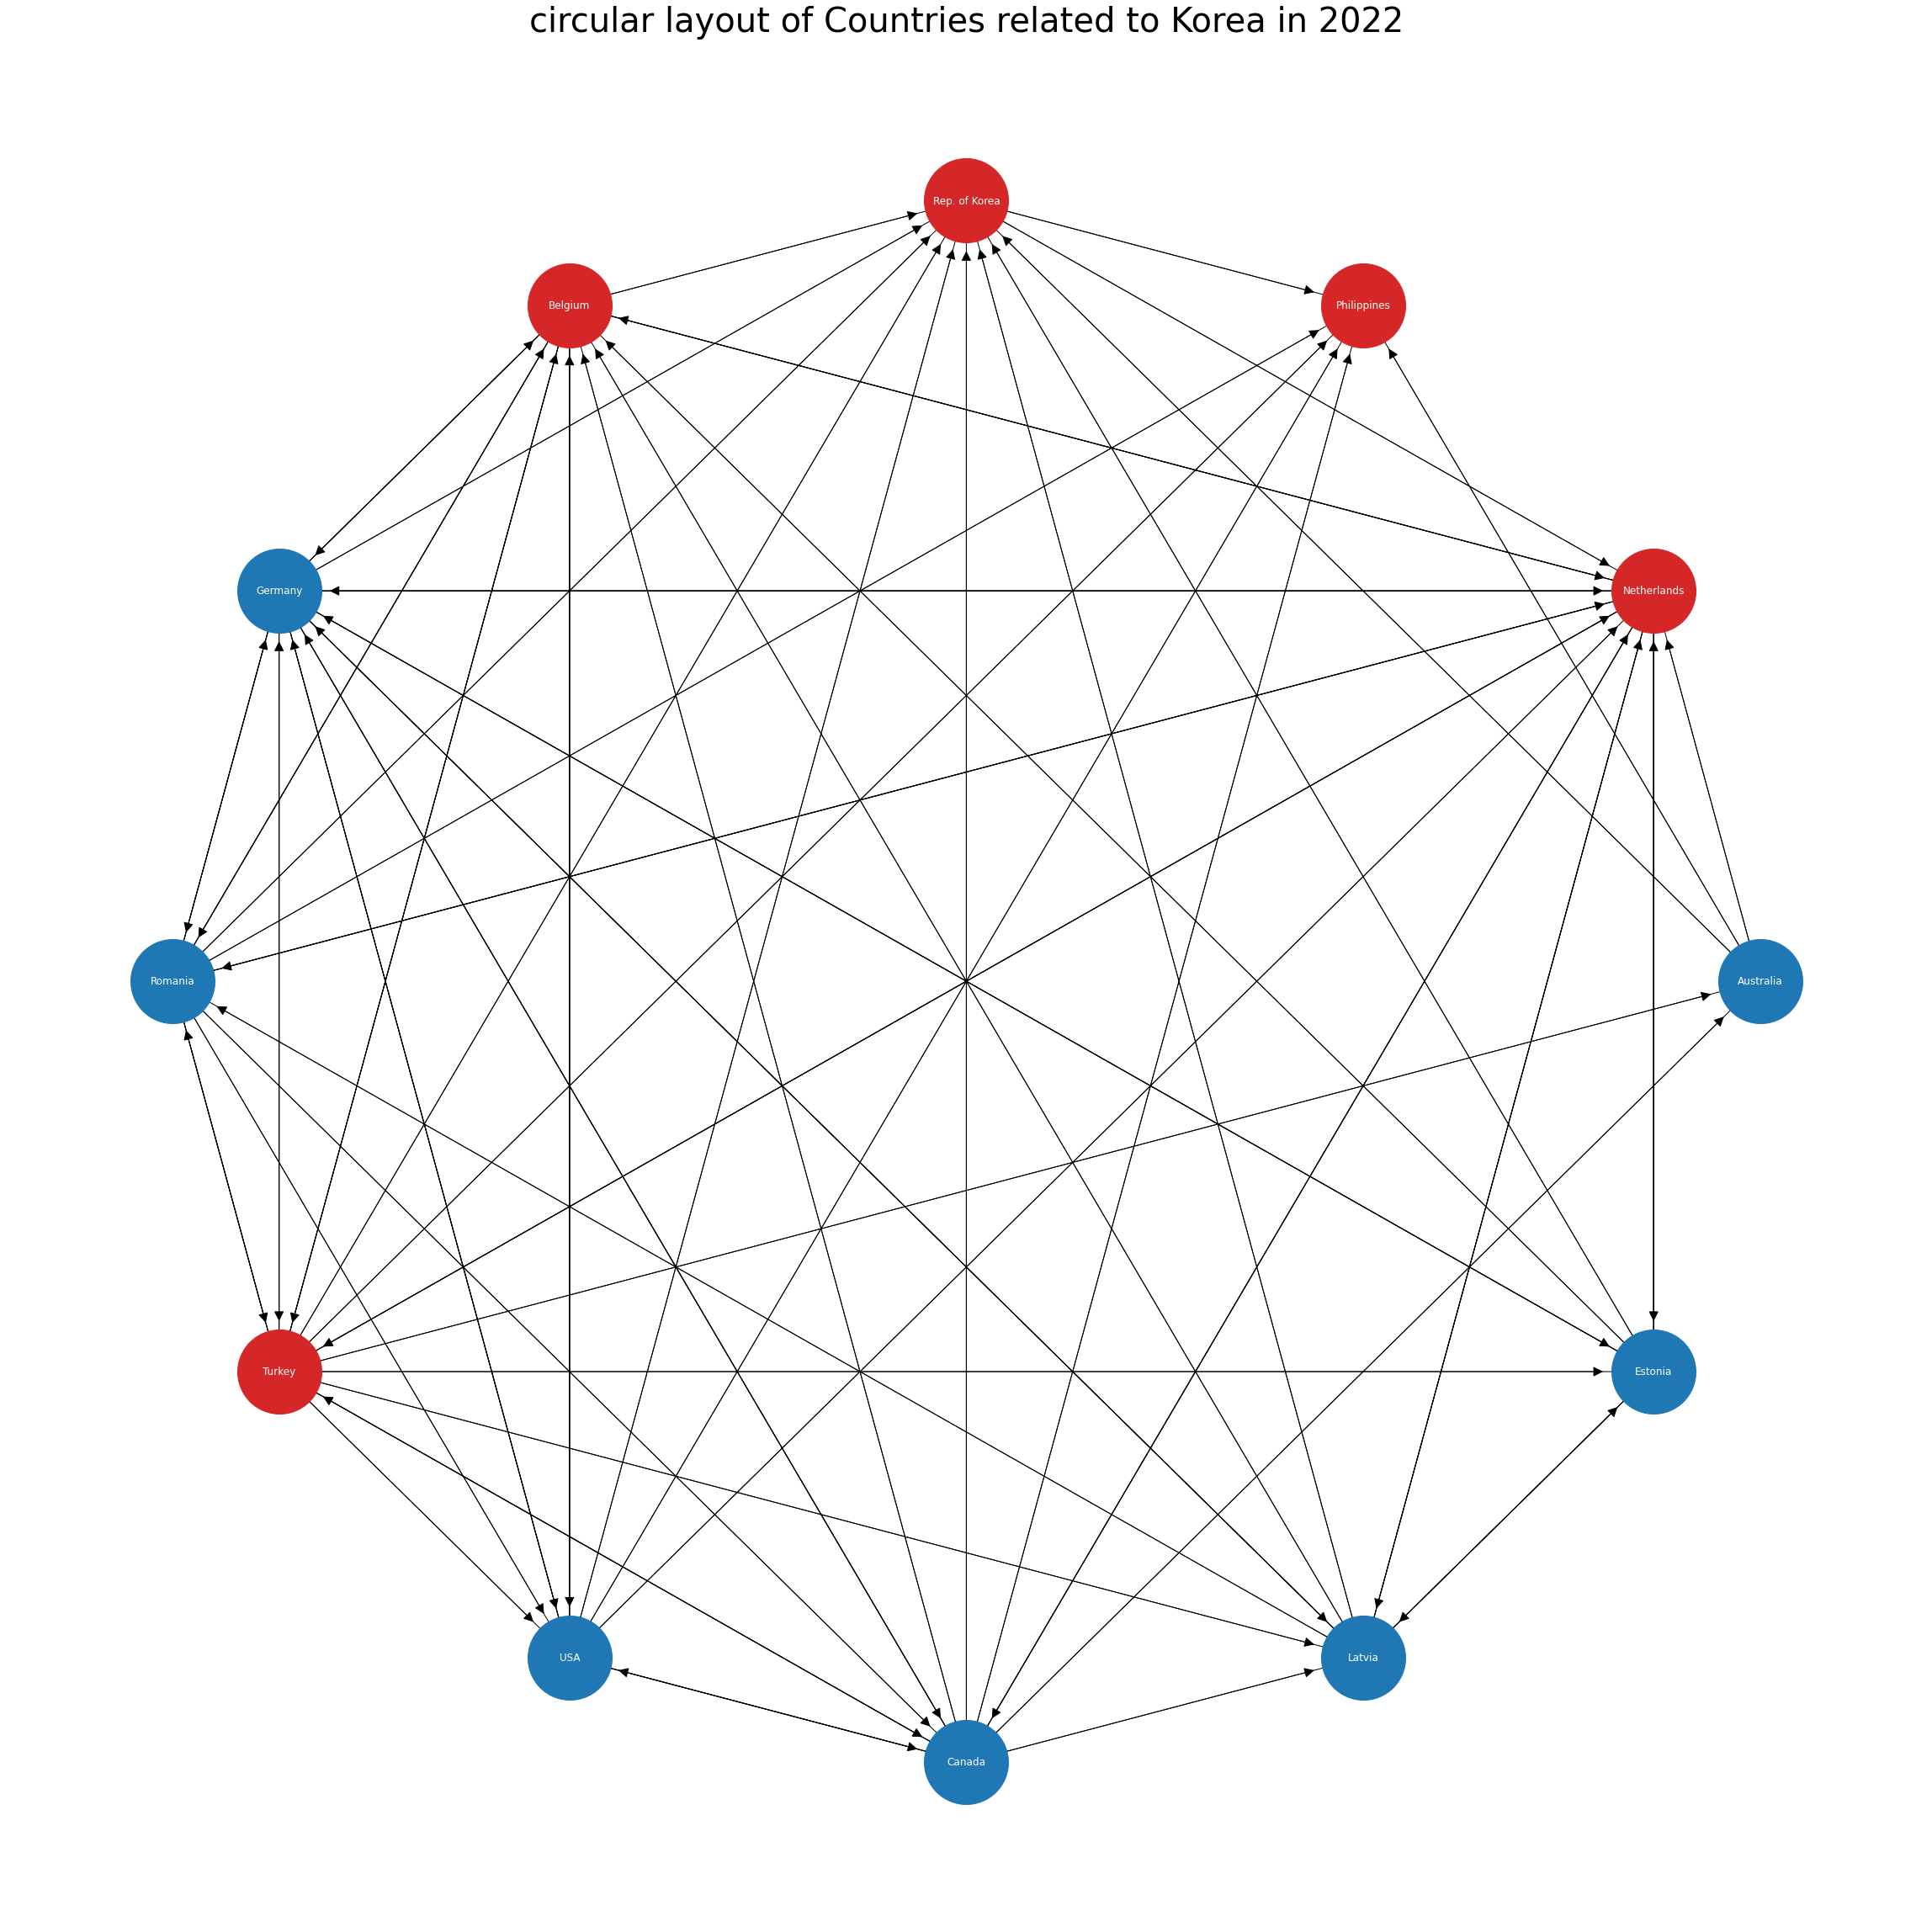

In [ ]:
# saving plot image
DiGraphPlot(wheat_korea, 2022)

## Centrality analysis

### return_centralities_as_dict()

In [ ]:
from networkx.algorithms.centrality.eigenvector import eigenvector_centrality

def return_centralities_as_dict(input_g):
    # weighted degree centrality를 딕셔너리로 리턴
    def return_weighted_degree_centrality(input_g, normalized=False):
        w_d_centrality = {n:0.0 for n in input_g.nodes()} # initialize
        for u, v, d in input_g.edges(data=True):
            w_d_centrality[u]+=d['Trade Value (US$)']
            w_d_centrality[v]+=d['Trade Value (US$)']
        if normalized==True:
            weighted_sum = sum(w_d_centrality.values())
            return {k:v/weighted_sum for k, v in w_d_centrality.items()}
        else:
            # print(w_d_centrality)
            return w_d_centrality

    def return_eigenvector_centrality(input_g):
        return nx.eigenvector_centrality(input_g, weight='Trade Value (US$)', max_iter=1000000000000) 
        # max_iter는 default 100으로 설정되어 미지정시 PowerIterationFailedConvergence 에러가 발생

    return {
        'weighted_deg':return_weighted_degree_centrality(input_g),
        'eigenvector_cent':return_eigenvector_centrality(input_g)
    }

In [ ]:
kor_ntwk_cenInfo = {}

kor_ntwk_cenInfo['wdeg'] = return_centralities_as_dict(wheat_korea)['weighted_deg']

kor_ntwk_cenInfo['weig'] = return_centralities_as_dict(wheat_korea)['eigenvector_cent']

In [ ]:
kor_ntwk_cenInfo.keys()

dict_keys(['wdeg', 'weig'])

In [ ]:
kor_ntwk_cenInfo.values()

dict_values([{'Australia': 1443995992.0, 'Netherlands': 1242980950.0, 'Philippines': 3113661577.0, 'Rep. of Korea': 997208407.0, 'Belgium': 967272232.0, 'Germany': 1435020986.0, 'Romania': 297653376.0, 'Turkey': 181318322.0, 'USA': 3282317913.0, 'Canada': 1344654373.0, 'Latvia': 116429456.0, 'Estonia': 38664824.0}, {'Australia': 2.686132890032233e-08, 'Netherlands': 0.8074938884457735, 'Philippines': 0.0007557998979182151, 'Rep. of Korea': 0.0008750614682210289, 'Belgium': 0.5609616173974172, 'Germany': 0.18241097641564813, 'Romania': 0.0007081905517840442, 'Turkey': 0.00016054372145528895, 'USA': 0.00011583242172333504, 'Canada': 4.2113257204624035e-05, 'Latvia': 0.00018345285952432361, 'Estonia': 8.057826317848145e-05}])

# Centrality 높은 상위 국가 판단

거래 금액을 weight로 지정한 아래의 두 Centrality를 이용해 파악해보았다.

degree centrality

eigenvector centrality

In [ ]:
# DataFrame으로 각 degree별 상위 국가 Top 5 파악, 한국이 포함될 것임로 6순위 까지

centrality = {}
centrality_df = {}

# weighted degree centrality
centrality['wdeg'] = [item for item, value in sorted(kor_ntwk_cenInfo['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:6]]

# weighted eigenvector centrality
centrality['weig'] = [item for item, value in sorted(kor_ntwk_cenInfo['weig'].items(), key=lambda x:x[1], reverse=True)[0:6]]

centrality_df = pd.DataFrame([
                              centrality['wdeg'],
                              centrality['weig']])

centrality_df.rename(
            columns={0:'1st', 1:'2nd', 2:'3rd', 3:'4th', 4:'5th', 5: '6th'},
            index = {
                      0:'weigthed degree centrality',
                      1:'weigthed eigenvector centrality' },inplace=True)


In [ ]:
year= 2022

print(f'weighted degree centrality in {year}:\n', sorted(kor_ntwk_cenInfo['wdeg'].items(), key=lambda x:x[1], reverse=True)[0:6], '\n')
print(f'weighted eigenvector centrality in {year}:\n', sorted(kor_ntwk_cenInfo['weig'].items(), key=lambda x:x[1], reverse=True)[0:6], '\n')

weighted degree centrality in 2022:
 [('USA', 3282317913.0), ('Philippines', 3113661577.0), ('Australia', 1443995992.0), ('Germany', 1435020986.0), ('Canada', 1344654373.0), ('Netherlands', 1242980950.0)] 

weighted eigenvector centrality in 2022:
 [('Netherlands', 0.8074938884457735), ('Belgium', 0.5609616173974172), ('Germany', 0.18241097641564813), ('Rep. of Korea', 0.0008750614682210289), ('Philippines', 0.0007557998979182151), ('Romania', 0.0007081905517840442)] 



In [ ]:
centrality_df

,1st,2nd,3rd,4th,5th,6th
weigthed degree centrality,USA,Philippines,Australia,Germany,Canada,Netherlands
weigthed eigenvector centrality,Netherlands,Belgium,Germany,Rep. of Korea,Philippines,Romania
